# Poiseuille Pipe (velocity-Neumann)

As for the case of a Poiseuille channel flow, this simulation is used as test for the outlet boundary condition with a fixed pressure. A velocity Bounce-Back BC is used at inlet, to provide an increase of pressure at inlet. The fixed pressure at outlet is meant to avoid a constant increase of the domain average density.

In [1]:
from nassu.cfg.model import ConfigScheme

filename = "tests/validation/cases/03_poiseuille_pipe_flow.nassu.yaml"

sim_cfgs = ConfigScheme.sim_cfgs_from_file_dct(filename)

The simulation parameters are shown below

In [2]:
from nassu.cfg.schemes.simul import SimulationConfigs
import pandas as pd

dct = {"N": [], "tau": [], "time_steps": []}


def add_to_dict(sim_cfg: SimulationConfigs):
    dct["N"].append(sim_cfg.domain.domain_size.y)
    dct["tau"].append(sim_cfg.models.LBM.tau)
    dct["time_steps"].append(sim_cfg.n_steps)


sim_cfg = next(
    sim_cfg
    for (name, _), sim_cfg in sim_cfgs.items()
    if name.startswith("velocityNeumannPoiseuillePipeMultilevel")
)
add_to_dict(sim_cfg)

df = pd.DataFrame(dct, index=None)

df

N   tau  time_steps
0  32  0.51       32000

In this case, the IBM domain limits for the $x$-direction must be set such that the the body is sufficiently far from domain's boundaries. Otherwise, numerical instability may be found.

Functions to use for processing of poiseuille pipe.

In [3]:
from typing import Callable
import numpy as np
from lnas import LnasFormat
from tests.validation.notebooks import common


def get_poiseuille_pipe_analytical_func() -> Callable:
    """Poiseuille analytical velocity function

    Returns:
        Callable[[float], float]: Analytical velocity function
    """
    return lambda r: 2 * (1 - r * r)


def get_poiseuille_pipe_numerical_avg_vel(ux_vals: np.ndarray) -> float:
    # Average velocity is ~half the maximun velocity.
    # Numerical integration gives worse results for average velocity
    return np.max(ux_vals) / 2


def get_pos_values_inside_pipe(sim_cfg: SimulationConfigs) -> np.ndarray:
    lnas_filename = sim_cfg.output.bodies["cylinder"].lnas_transformed
    lnas = LnasFormat.from_file(lnas_filename)
    vertices = lnas.geometry.vertices

    x_val = sim_cfg.domain.domain_size.x * 3 // 4 + 2
    z_val = sim_cfg.domain.domain_size.z / 2
    min_y, max_y = (vertices[:, 1].min(), vertices[:, 1].max())
    min_y, max_y = int(np.floor(min_y)), int(np.ceil(max_y))

    p1, p2 = (x_val, min_y, z_val), (x_val, max_y, z_val)
    line = np.linspace(p1, p2, num=max_y - min_y, endpoint=False)
    return line


def get_pos_values_along_pipe(sim_cfg: SimulationConfigs) -> np.ndarray:
    min_x, max_x = 0, sim_cfg.domain.domain_size.x - 1
    y_val = sim_cfg.domain.domain_size.y / 2
    z_val = sim_cfg.domain.domain_size.z / 2

    p1, p2 = (min_x, y_val, z_val), (max_x, y_val, z_val)
    line = np.linspace(p1, p2, num=max_x - min_x, endpoint=False)
    return line


def plot_analytical_poiseuille_pipe_vels(ax):
    x = np.arange(
        -1,
        1.01,
        0.01,
    )
    analytical_func = get_poiseuille_pipe_analytical_func()
    analytical_data = analytical_func(x)
    ax.plot(x, analytical_data, "--k", label="Analytical")

## Results


Extract the velocity profile from simulation

In [4]:
import numpy as np
from vtk.util.numpy_support import vtk_to_numpy

extracted_data = {}
array_to_extract = "ux"

export_instantaneous_cfg = sim_cfg.output.instantaneous
macr_export = export_instantaneous_cfg["default"]
time_step = macr_export.time_steps(sim_cfg.n_steps)[-1]
reader = macr_export.read_vtm_export(time_step)

pos = get_pos_values_inside_pipe(sim_cfg)

# Sum 0.5 because data is cell data, so it's in the center of the cell
p1 = pos[0] + 0.5
p2 = pos[-1] + 0.5

line = common.create_line(p1, p2, len(pos) - 1)

# Get the points from the vtkLineSource
polyData = line.GetOutput()
points = polyData.GetPoints()

probe_filter = common.probe_over_line(line, reader.GetOutput())

probed_data = vtk_to_numpy(probe_filter.GetOutput().GetPointData().GetArray(array_to_extract))
extracted_data = {"pos": pos, "data": probed_data}

Extract velocity along the pipe

In [5]:
ux_along_pipe = {}

pos = get_pos_values_along_pipe(sim_cfg)
# Sum 0.5 because data is cell data, so it's in the center of the cell
p1 = pos[0] + 0.5
p2 = pos[-1] + 0.5

line = common.create_line(p1, p2, len(pos) - 1)

# Get the points from the vtkLineSource
polyData = line.GetOutput()
points = polyData.GetPoints()

probe_filter = common.probe_over_line(line, reader.GetOutput())

probed_data = vtk_to_numpy(probe_filter.GetOutput().GetPointData().GetArray(array_to_extract))
ux_along_pipe = {"pos": pos, "data": probed_data}

The velocity profile at the end of simulation is compared with the steady state analytical solution below:

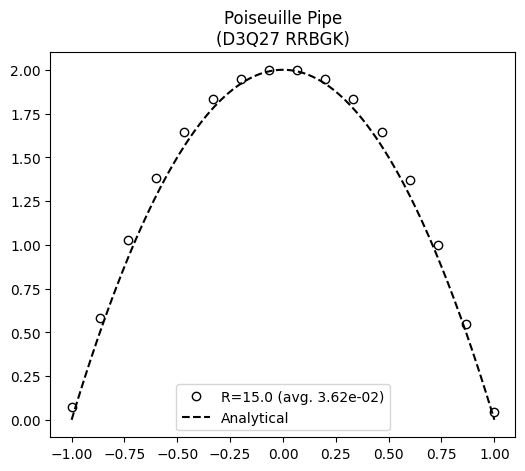

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(6, 5)


def normalize_pos(pos):
    # Normalize between -1 and 1
    pos -= pos.min()
    pos /= pos.max()
    pos -= 0.5
    pos *= 2


num_data = extracted_data
num_avg_vel = get_poiseuille_pipe_numerical_avg_vel(extracted_data["data"])
pos_norm = extracted_data["pos"][:, 1].copy()
R = pos_norm.max() - pos_norm.min()
normalize_pos(pos_norm)

ax.plot(
    pos_norm,
    extracted_data["data"] / num_avg_vel,
    "o",
    label=f"R={R} (avg. {num_avg_vel:.2e})",
    fillstyle="none",
    c="k",
)

plot_analytical_poiseuille_pipe_vels(ax)
ax.set_title(f"Poiseuille Pipe\n({sim_cfg.models.LBM.vel_set} {sim_cfg.models.LBM.coll_oper})")
ax.legend()
plt.show(fig)

Good agreement was also obtained for this case, with an coherent flow development.

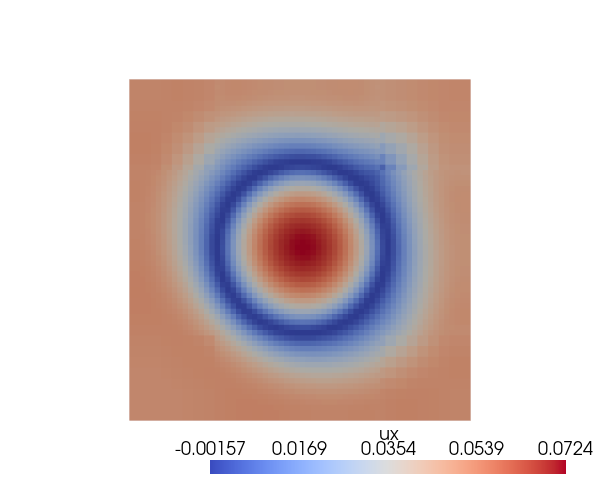

[(165.42562584220408, 16.0, 16.0),
 (78.0, 16.0, 16.0),
 (0.0, 0.0, 1.0)]

In [7]:
import pyvista as pv

array_to_inspect = "ux"

time_step = macr_export.time_steps(sim_cfg.n_steps)[-1]
multiblock_file = macr_export.time_step_filename(time_step, ".vtm")
multi_block = pv.read(multiblock_file)

sliced_blocks = multi_block.slice(
    normal=[1, 0, 0], origin=[3 * sim_cfg.domain.domain_size.x // 4, 0, 0]
)

plotter = pv.Plotter(window_size=(600, 500))
sliced_blocks.set_active_scalars(array_to_inspect)
plotter.add_mesh(sliced_blocks, cmap="coolwarm")
plotter.show(jupyter_backend="static", cpos="yz", return_cpos=True)

The sectional view of the flow profile shows a axissymmetric flow with a secundary flow ocurring between the IBM body and the boundaries.

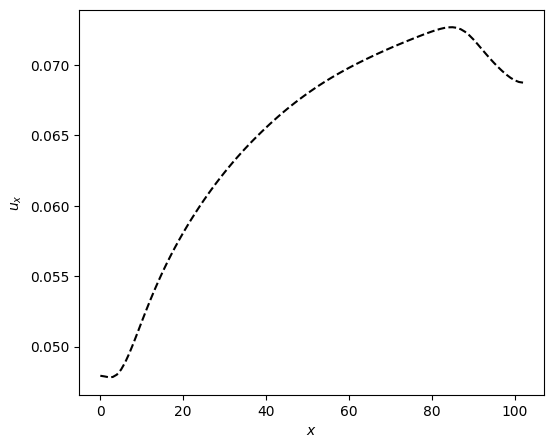

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(6, 5)

ax.plot(
    ux_along_pipe["pos"][:, 0],
    ux_along_pipe["data"],
    "--",
    label="Nassu",
    fillstyle="none",
    c="k",
)

ax.set_ylabel("$u_x$")
ax.set_xlabel("$x$")
plt.show(fig)

The centerline velocity is shown above. It presents asymptotic decay as for the turbulent channel. However, at the end of IBM domain limits, the flow suffers an expansion and the centerline velocity reduces.

## Version

In [9]:
sim_info = sim_cfg.output.read_info()

nassu_commit = sim_info["commit"]
nassu_version = sim_info["version"]
print("Version:", nassu_version)
print("Commit hash:", nassu_commit)

Version: 1.6.17
Commit hash: 48c3911fcbd40fb096668a94ece2ff27dac22996


## Configuration

In [10]:
from IPython.display import Code

Code(filename=filename)

simulations:
  - name: periodicPoiseuillePipeN16
    save_path: ./tests/validation/results/03_poiseuille_pipe_flow/periodic
    run_simul: false
    n_steps: 2000
    report:
      frequency: 1000

    data:
      divergence: { frequency: 50 }
      instantaneous:
        default: { interval: { frequency: 0 }, macrs: [rho, u, f_IBM, S] }

    domain:
      domain_size:
        x: 24
        y: 24
        z: 24
      block_size: 8

      bodies:
        cylinder:
          lnas_path: fixture/lnas/basic/cylinder.lnas
          small_triangles: add
          transformation:
            scale: [8, 8, 8]
            translation: [-4, 4, 4]

    models:
      precision:
        default: single

      LBM:
        tau: 0.8
        F:
          x: 6.25E-05
          y: 0
          z: 0
        vel_set: D3Q27
        coll_oper: RRBGK

      engine:
        name: CUDA

      IBM:
        forces_accomodate_time: 1000
        body_cfgs:
          default: {}

      BC:
        periodic_dims: [true, false, false]
        BC_map:
          - pos: N
            BC: RegularizedHWBB
            wall_normal: N
            order: 1

          - pos: S
            BC: RegularizedHWBB
            wall_normal: S
            order: 1

          - pos: F
            BC: RegularizedHWBB
            wall_normal: F
            order: 2

          - pos: B
            BC: RegularizedHWBB
            wall_normal: B
            order: 2

  - name: periodicPoiseuillePipeN32
    parent: periodicPoiseuillePipeN16

    n_steps: 8000

    domain:
      domain_size:
        x: 40
        y: 40
        z: 40
      block_size: 8
      bodies: !not-inherit
        cylinder:
          lnas_path: fixture/lnas/basic/cylinder.lnas
          small_triangles: add
          transformation:
            scale: [16, 16, 16]
            translation: [-4, 4, 4]

    models:
      LBM:
        F:
          x: 7.8125E-06
          y: 0
          z: 0

  - name: periodicPoiseuillePipeN64
    parent: periodicPoiseuillePipeN16

    n_steps: 32000

    domain:
      domain_size:
        x: 72
        y: 72
        z: 72
      block_size: 8
      bodies: !not-inherit
        cylinder:
          lnas_path: fixture/lnas/basic/cylinder.lnas
          small_triangles: add
          transformation:
            scale: [32, 32, 32]
            translation: [-4, 4, 4]
    models:
      LBM:
        F:
          x: 9.76563E-07
          y: 0
          z: 0

  - name: periodicPoiseuillePipeN128
    parent: periodicPoiseuillePipeN16

    n_steps: 128000

    domain:
      domain_size:
        x: 136
        y: 136
        z: 136
      block_size: 8
      bodies: !not-inherit
        cylinder:
          lnas_path: fixture/lnas/basic/cylinder.lnas
          small_triangles: add
          transformation:
            scale: [64, 64, 64]
            translation: [-4, 4, 4]
    models:
      LBM:
        F:
          x: 1.22070E-07
          y: 0
          z: 0

  - name: velocityNeumannPoiseuillePipeMultilevel
    save_path: ./tests/validation/results/03_poiseuille_pipe_flow/velocity_neumann_multilevel

    n_steps: 32000

    report:
      frequency: 1000

    data:
      divergence: { frequency: 1 }
      instantaneous:
        default: { interval: { frequency: 8000 }, macrs: [rho, u, f_IBM, S] }

    domain:
      domain_size:
        x: 104
        y: 32
        z: 32

      block_size: 8
      bodies_domain_limits:
        start: [4, 8, 8]
        end: [88, 40, 40]
        is_abs: true
      bodies:
        cylinder:
          lnas_path: fixture/lnas/basic/cylinder.lnas
          small_triangles: add
          transformation:
            scale: [8, 8, 8]
            translation: [4, 8, 8]
      refinement:
        static:
          default:
            bodies:
              - body_name: cylinder
                lvl: 1
                normal_offsets: [-2, 0, 2]

    models:
      precision:
        default: single

      LBM:
        tau: 0.51
        vel_set: D3Q27
        coll_oper: RRBGK

   